In [0]:
NB_EPOCHS = 20
BATCH_SIZE = 256

In [0]:
%tensorflow_version 2.x

In [10]:
import numpy as np
import tensorflow as tf
import pandas as pd
import gc, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

tf.__version__

'2.0.0'

##Rebuild train and test sets from input files
1. upload the interactions_train.csv and interactions_test.csv
2. execute next cell

In [11]:
train_matrix = pd.read_csv('./interactions_train_alt.csv').pivot_table(index='u', columns='i', values='rating', dropna=False)
print(f'Shape of train User-Movie-Matrix:\t{train_matrix.shape}')
test_matrix = pd.read_csv('./interactions_test_alt.csv').pivot_table(index='u', columns='i', values='rating', dropna=False)
print(f'Shape of test User-Movie-Matrix:\t{test_matrix.shape}')

Shape of train User-Movie-Matrix:	(6384, 3148)
Shape of test User-Movie-Matrix:	(6384, 3148)


In [0]:
#normalize data by dividing by 5 as ratings go from 0 to 5
train_matrix = train_matrix / 5
test_matrix = test_matrix /5

In [0]:
#replace all missing rating by -1 (as rating are from 0 to 5)
#the -1 will be then used in the model loss function as a mask
train_matrix.fillna(-1, inplace=True)
test_matrix.fillna(-1, inplace=True)

#Build the model

In [0]:
def BuildAEModel(n_recipes, activation=None):
    inputs = tf.keras.layers.Input((n_recipes,))
    #encoded_layer1 = tf.keras.layers.Dense(8192,activation=None, name='Encoder_Layer_1')(inputs)
    encoded_layer2 = tf.keras.layers.Dense(4096,activation=None, name='Encoder_Layer_2')(inputs)
    #encoded_layer3 = tf.keras.layers.Dense(2048,activation=None, name='Encoder_Layer_3')(encoded_layer2)
    
    embedded = tf.keras.layers.Dense(2048,activation=activation, name='embedder')(encoded_layer2)
    
    #decoded_layer1 = tf.keras.layers.Dense(2048,activation=None, name='Decoder_Layer_1')(embedded)
    decoded_layer2 = tf.keras.layers.Dense(4096,activation=None, name='Decoder_Layer_2')(embedded)
    #decoded_layer3 = tf.keras.layers.Dense(8192,activation=None, name='Decoder_Layer_3')(decoded_layer2)
    
    outputs = tf.keras.layers.Dense(n_recipes, activation='linear', name = 'Reconstructor')(decoded_layer2)
    
    model = tf.keras.Model(inputs=inputs, outputs = [outputs])
    return model

## define a specific loss function 
- to compare recipes rating for only rated recipes, ie recipes that have values <> -1
- For those recipes, mse will be computed

In [0]:
def customMaskedMSE(ytrue, ypred):
  mask = tf.not_equal(ytrue, -1)
  return tf.keras.backend.mean(tf.keras.backend.square(tf.boolean_mask(ytrue - ypred, mask)))

def customMaskedMAE(ytrue, ypred):
  mask = tf.not_equal(ytrue, -1)
  return tf.keras.backend.mean(tf.keras.backend.abs(tf.boolean_mask(ytrue - ypred, mask)))

In [16]:
my_model = BuildAEModel(train_matrix.shape[1], 'relu')
my_model.summary()
adam = tf.keras.optimizers.Adam(0.001)
my_model.compile('adam',loss=customMaskedMSE)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3148)]            0         
_________________________________________________________________
Encoder_Layer_2 (Dense)      (None, 4096)              12898304  
_________________________________________________________________
embedder (Dense)             (None, 2048)              8390656   
_________________________________________________________________
Decoder_Layer_2 (Dense)      (None, 4096)              8392704   
_________________________________________________________________
Reconstructor (Dense)        (None, 3148)              12897356  
Total params: 42,579,020
Trainable params: 42,579,020
Non-trainable params: 0
_________________________________________________________________


## start the training

In [0]:
#@title callbacks
class LRFinder(tf.keras.callbacks.Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        self.iteration += 1

        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [0]:
# This function decrease the learning rate by 10 at each 10 epoch
def scheduler(epoch):
    return 0.001 * np.power(0.1, epoch//10)

#setup the callbacks for the model
callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)]
#callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=3, verbose=1, min_delta=0.01), 
#             tf.keras.callbacks.EarlyStopping(monitor = 'loss',patience = 20)]
#callbacks = []

In [19]:
hist = my_model.fit(train_matrix.values, train_matrix.values,
                    epochs=NB_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Train on 6384 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
6384/6384 [==============================] - 2s 317us/sample - loss: 34.2307

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
6384/6384 [==============================] - 0s 72us/sample - loss: 0.1506

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/20
6384/6384 [==============================] - 0s 72us/sample - loss: 0.1224

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/20
6384/6384 [==============================] - 0s 73us/sample - loss: 0.0435

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/20
6384/6384 [==============================] - 0s 71us/sample - loss: 0.0359

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.
Epoch 6/20
6384/6384 [==============================] - 0s 71us/sample - loss: 0.0358

Epoch 00007: LearningRateScheduler reducing l

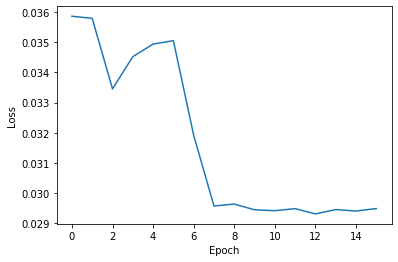

In [20]:
plt.plot(hist.history['loss'][4:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
#evaluation on the train set
my_model.evaluate(train_matrix.values, train_matrix.values, verbose=1)

6384/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.03157071307544272

In [22]:
#evaluation on the test set
my_model.evaluate(train_matrix.values, test_matrix.values, verbose=1)

6384/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.049544731122359895

# Save model on google drive for local evaluation

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
my_model.save("/content/drive/My Drive/ML/ae.h5",include_optimizer=False)

##compare predictions with test data for a user

In [27]:
#getting user train ratings
#id = 24240
id=33
user = train_matrix[train_matrix.index == id].T
user_ratings_train = user[user[id]!=-1].T

#getting user test ratings
user = test_matrix[test_matrix.index == id].T
user_ratings_test = user[user[id]!=-1].T

display(user_ratings_train)
display(user_ratings_test)

i,13616,19812,69992,72296,78451,83310,87565,97450,101200,129723,135400,164348
u,,,,,,,,,,,,
33,0.6,0.8,0.6,1.0,1.0,0.4,0.8,0.8,1.0,0.8,0.8,0.4


i,2949,134610,149428,166633
u,,,,
33,1.0,1.0,1.0,1.0


In [28]:
#get predictions from model
user_train = train_matrix[train_matrix.index == id].values
preds = my_model.predict(user_train, verbose=1)
preds = pd.DataFrame(preds, columns = train_matrix.columns)

1/1 [==============================] - 0s 36ms/sample


In [29]:
#user mse
np.square(preds[user_ratings_train.columns].values - user_ratings_train.values).mean()

0.053136604645390655

In [30]:
#user prediction for train recipes
preds[user_ratings_train.columns]

i,13616,19812,69992,72296,78451,83310,87565,97450,101200,129723,135400,164348
0,0.937084,0.884654,0.827639,0.946916,0.904042,0.800202,0.919922,0.912623,0.894378,0.962271,0.952174,0.852913


In [31]:
#user prediction for test recipes
preds[user_ratings_test.columns]

i,2949,134610,149428,166633
0,0.945005,0.857121,0.944583,0.948724


In [32]:
#top 10 recipes
reco = preds[set(preds.columns) - set (user_ratings_train.columns)].T.sort_values([0],ascending=False)
reco_top10 = reco.head(10)
display(reco_top10)
reco_top10.index

,0
i,
34328,1.014472
164559,1.012890
172186,1.011370
48842,1.011244
90165,1.010524
72387,1.010383
39456,1.008332
34759,1.008225
48614,1.006480


Int64Index([34328, 164559, 172186, 48842, 90165, 72387, 39456, 34759, 48614,
            48542],
           dtype='int64', name='i')

In [33]:
#get positions of user test recipes in recommandation from autoencoder
for recipe in user_ratings_test.columns:
  print('recipe ID :', recipe, 'position in reco :', str(reco.index.get_loc(recipe)) + '/' + str(len(train_matrix)))


recipe ID : 2949 position in reco : 932/6384
recipe ID : 134610 position in reco : 2845/6384
recipe ID : 149428 position in reco : 947/6384
recipe ID : 166633 position in reco : 827/6384


## output index for local analysis 
(data source too big for colab)

In [0]:
#the train recipes from user
print(user_ratings_train.columns)
#the top 10 recommanded recipes
print(reco_top10.index)